In [1]:
# import modules 
% matplotlib inline

import os
import pylab
import random
import numpy as np
import pandas as pd
import cPickle as pkl
from lasagne import layers, updates
from scipy.misc import imread, imresize
from lasagne.nonlinearities import softmax
from sklearn.preprocessing import MinMaxScaler
from nolearn.lasagne import NeuralNet, BatchIterator
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.feature_extraction.image import extract_patches

project_root = 'workspace/.project/project'
data_root = os.path.join(os.path.expanduser('~'), project_root, 'datasets')
model_root = os.path.join(os.path.expanduser('~'), project_root, 'models')

icdar_root = 'icdar15/'
test_root = 'Challenge2_Test_Task3_Images'

alphabet = 'abcdefghijklmnopqrstuvwxyz'
test_size = 1095

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [2]:
# load pre-trained models
with open(os.path.join(model_root, 'detector_2.pkl'), 'rb') as f:
    detector = pkl.load(f)

f.close()

with open(os.path.join(model_root, 'recognizer.pkl'), 'rb') as f:
    recognizer = pkl.load(f)

f.close()

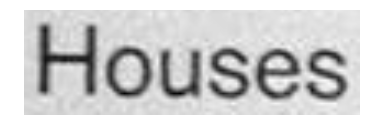

In [279]:
i = random.randrange(0,test_size)

img = imread(os.path.join(data_root, icdar_root, test_root, ('word_' + str(i) + '.png')), flatten = True)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
pylab.show()

image_height = img.shape[0]
image_width = img.shape[1]

In [280]:
# extract patches
patch_height = image_height
patch_width = image_height*0.6
patches = extract_patches(img, (patch_height, patch_width))

In [281]:
# set shape as 32x32 and stack patches
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, :, :], (32, 32)))
        
new_list = np.stack(new_lst)
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32).astype('float32')

In [282]:
# normalize patches
tester /= tester.std(axis = None)
tester -= tester.mean()

In [283]:
# detect text patches
predict_detect = detector.predict_proba(tester)

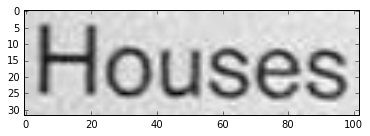

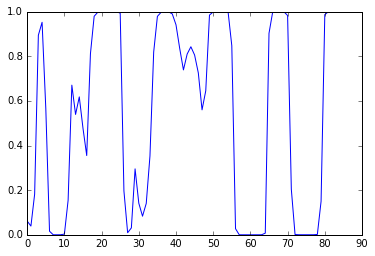

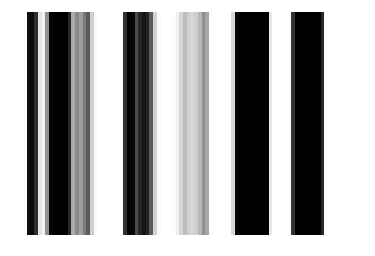

In [284]:
# plot heatmap
heatmap = predict_detect[:, 1].reshape((patches.shape[0], patches.shape[1]))

pylab.imshow(img)
pylab.gray()
pylab.show()

predict_signal = np.reshape(heatmap, patches.shape[1]*patches.shape[0])
pylab.plot(predict_signal)
pylab.show()

pylab.pcolor(heatmap[::-1])
pylab.gray()
pylab.axis('off')
pylab.show()

In [285]:
from scipy.ndimage.filters import maximum_filter

In [286]:
peakind = np.nonzero(maximum_filter(predict_signal, size=(patches.shape[1] / 5)*0.75) == predict_signal)[0]
peakind

array([ 4, 22, 37, 52, 67, 82])

In [287]:
x_1 = np.arange(patches.shape[1])
y_1 = np.zeros(patches.shape[1])
x_2 = np.arange(32, patches.shape[1] + 32)
y_2 = np.ones(patches.shape[1])
scores_ = predict_signal

boxes = np.stack((x_1, y_1, x_2, y_2, scores_)).T

In [288]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return np.sort(np.array(keep, dtype = int))

In [293]:
peakind = nms(boxes,thresh=0.4) # tresh??
peakind

array([ 4, 22, 37, 52, 67, 82])

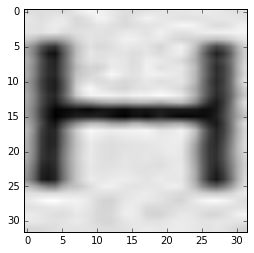

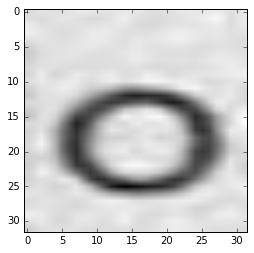

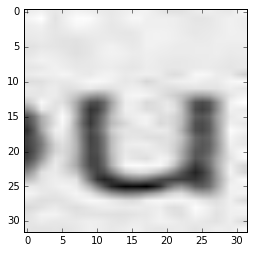

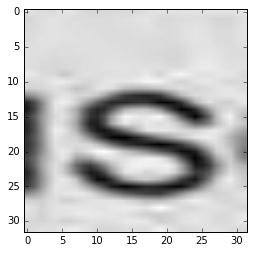

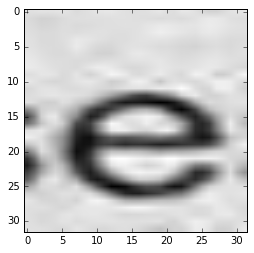

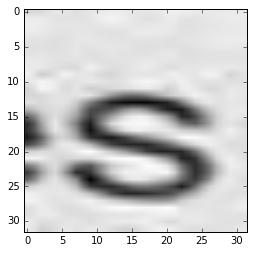

In [294]:
# show detected patches
for i in peakind:
    pylab.imshow(tester[i, 0, :, :])
    pylab.gray()
    pylab.show()

In [210]:
patches.shape

(1, 403, 82, 49)

In [16]:
peakind

array([ 2, 10, 16, 24, 30])

In [17]:
np.sort(peakind)

array([ 2, 10, 16, 24, 30])